In [1]:
import sys
import os
import pandas as pd
import datetime as datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import OneHotEncoder
import matplotlib
import matplotlib.pyplot as plt
#import psycopg2
from scipy.stats import ks_2samp
import scipy.stats as scats
# import visuals as vs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from heapq import nlargest
plt.style.use('ggplot') 
%matplotlib inline

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer


from icu_mortality_prediction import DATA_DIR

# MIMIC-III Critical Care Database

MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

The database includes information such as demographics, vital sign measurements made at the bedside (~1 data point per hour), laboratory test results, procedures, medications, caregiver notes, imaging reports, and mortality (both in and out of hospital).

MIMIC supports a diverse range of analytic studies spanning epidemiology, clinical decision-rule improvement, and electronic tool development. It is notable for three factors:

it is freely available to researchers worldwide
it encompasses a diverse and very large population of ICU patients
it contains high temporal resolution data including lab results, electronic documentation, and bedside monitor trends and waveforms.

Citations: 
MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. Available at: http://www.nature.com/articles/sdata201635

Pollard, T. J. & Johnson, A. E. W. The MIMIC-III Clinical Database http://dx.doi.org/10.13026/C2XW26 (2016).



# IMPORTING LAB DATA
The mimic III database was downloaded and reconstructed locally using posgresql. The database was managed graphically using Portico. 
A query was run on the mimic III database to generate chart data for the first 24hrs of a patients icu stay as well as demographic data for patients diagnosed with sepsis according to the Angus criteria. 
(Angus et al, 2001. Epidemiology of severe sepsis in the United States; http://www.ncbi.nlm.nih.gov/pubmed/11445675 )

The query was exported from Porticoto the file LAB_EVENTS_ANGUS_FIRST24.csv. The data was read into a pandas dataframe lab_events. 


# DEBUG START

In [2]:
lab_events_raw_df = pd.read_csv(os.path.join(DATA_DIR, 'raw','D_LABITEMS.csv'))


In [3]:
lab_events_raw_df[lab_events_raw_df['LABEL']=='pH'].head()

,ROW_ID,ITEMID,LABEL,FLUID,CATEGORY,LOINC_CODE
147,21,50820,pH,Blood,Blood Gas,11558-4
158,32,50831,pH,Other Body Fluid,Blood Gas,2748-2
420,294,51094,pH,Urine,Chemistry,2756-5
690,691,51491,pH,Urine,Hematology,5803-2


# DEBUG STOP

In [4]:
lab_events_filename = 'LAB_EVENTS_FIRST24.csv'
lab_events_filepath = os.path.join(DATA_DIR, 'interim',lab_events_filename)
lab_events_data_df = pd.read_csv(lab_events_filepath) #, index_col = 'icustay_id')

lab_events_data_df.loc[:,'charttime']  = pd.to_datetime(lab_events_data_df.loc[:,'charttime'])
lab_events_data_df = lab_events_data_df.sort_values(['icustay_id', 'charttime'],ascending=True)
# lab_events_data_df.drop(['charttime'], axis=1, inplace=True)
lab_events_data_df.head()

,subject_id,icustay_id,gender,label,charttime,valuenum,flag,hospital_expire_flag
714216,55973,200001,F,Hematocrit,2181-11-25 16:16:00,26.10,abnormal,0
714217,55973,200001,F,White Blood Cells,2181-11-25 16:16:00,2.90,abnormal,0
714218,55973,200001,F,pH,2181-11-25 17:00:00,5.00,NaN,0
714219,55973,200001,F,Lactate,2181-11-25 19:27:00,1.40,NaN,0
714220,55973,200001,F,pH,2181-11-25 19:27:00,7.41,NaN,0


In [5]:
# Creates column name variables. 
lab_value = 'valuenum'
lab_label = 'label'
gender = 'gender'
label = 'label'
valuenum = 'valuenum'
hospital_expire_flag = 'hospital_expire_flag'


In [6]:
lab_events_data_df.head()

,subject_id,icustay_id,gender,label,charttime,valuenum,flag,hospital_expire_flag
714216,55973,200001,F,Hematocrit,2181-11-25 16:16:00,26.10,abnormal,0
714217,55973,200001,F,White Blood Cells,2181-11-25 16:16:00,2.90,abnormal,0
714218,55973,200001,F,pH,2181-11-25 17:00:00,5.00,NaN,0
714219,55973,200001,F,Lactate,2181-11-25 19:27:00,1.40,NaN,0
714220,55973,200001,F,pH,2181-11-25 19:27:00,7.41,NaN,0


In [7]:
# Creates copy of the lab_events_data_df dataframe for visualization exploration
aggregate_lab_values_for_visualization_df = lab_events_data_df[[gender, 
                                                             hospital_expire_flag, 
                                                            label, 
                                                            valuenum]]

In [8]:
# Generates counts for different types of lab measurements
lab_measurement_type_counts = lab_events_data_df['label'].value_counts()


lab_measurement_type_counts

pH                            218882
Hematocrit                    166293
White Blood Cells             130909
Creatinine                    130258
Glucose                       119726
Lactate                        88289
Oxygen Saturation              61903
Lactate Dehydrogenase (LD)     19261
Creatinine, Urine               7397
WBC Count                        177
24 hr Creatinine                  21
Urine Creatinine                   4
Name: label, dtype: int64

In [9]:
# Create a list of lab measurement types with counts greater than 5k. 
# Removes sparse lab values. 
lab_measurement_types = list(lab_measurement_type_counts[
                                        lab_measurement_type_counts>5000
                                                        ].index)


In [10]:
lab_measurement_types

['pH',
 'Hematocrit',
 'White Blood Cells',
 'Creatinine',
 'Glucose',
 'Lactate',
 'Oxygen Saturation',
 'Lactate Dehydrogenase (LD)',
 'Creatinine, Urine']

# Plot Distributions for All Lab Measurements By Gender and Survivor Status

In [11]:
def generate_gender_survivor_cohorts(lab_events_data_df, gend='F', expired=True):
    gender_survivor_cohort_df = lab_events_data_df[
                                 (lab_events_data_df[label]==lab_measurement)&             
                                 (lab_events_data_df[hospital_expire_flag]==expired)& 
                                 (lab_events_data_df[gender] == gend)
                                ]
    if gend==1:
        gender_survivor_cohort_df.name = 'Survivors'
    else:
        gender_survivor_cohort_df.name = 'Non_Survivors'
    return gender_survivor_cohort_df

In [12]:
def plot_gender_survivor_lab_values_distributions(survivors, non_survivors, lab_value):    
    plt.subplots(figsize=(10,4))
    survivors[lab_value].plot.hist(
                                bins=100, 
                                alpha=1.0,
                                label='Survival'
    )

    non_survivors[lab_value].plot.hist(
                                bins=100,
                                alpha=1.0,
                                label='Non-Survivors')
    # add title, labels etc.
    plt.title('{} measurement on ICU admission'.format(lab_measurement) + 
               'vs ICU mortality by gender = {}\n'.format(gend))
    plt.xlabel(lab_measurement)
    plt.legend(loc="upper left", bbox_to_anchor=(.75,.75),fontsize=12)

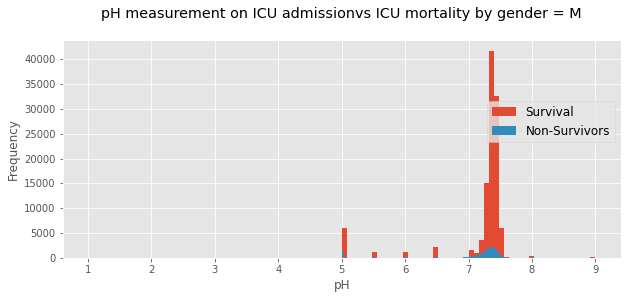

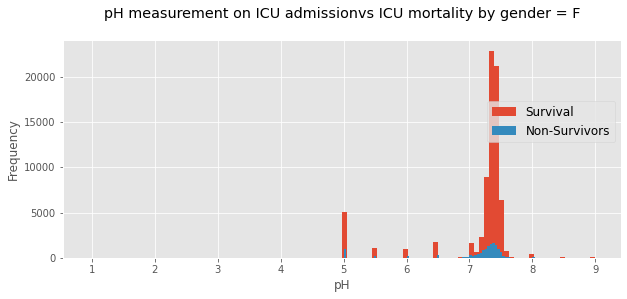

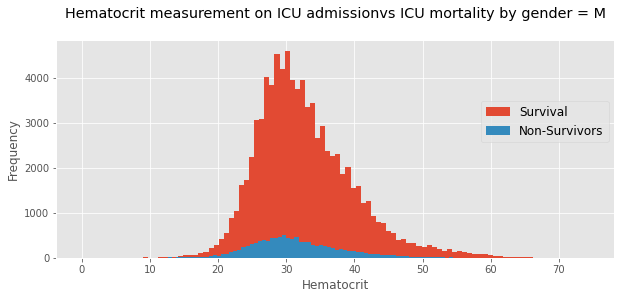

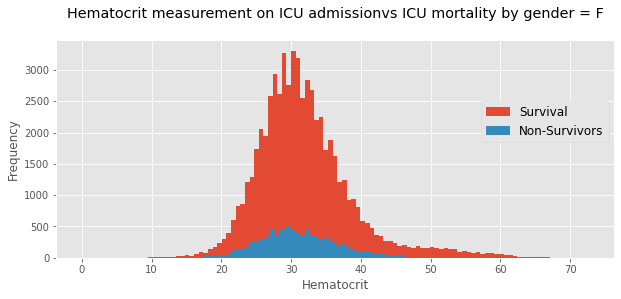

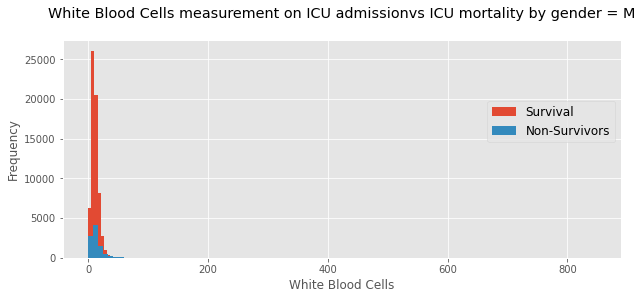

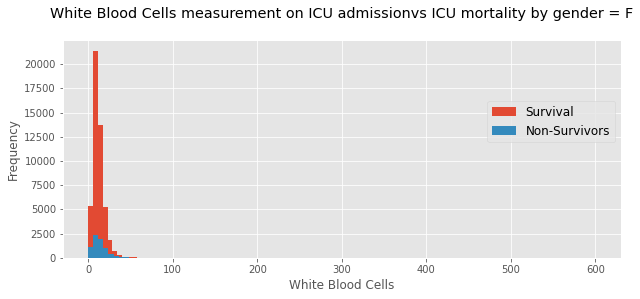

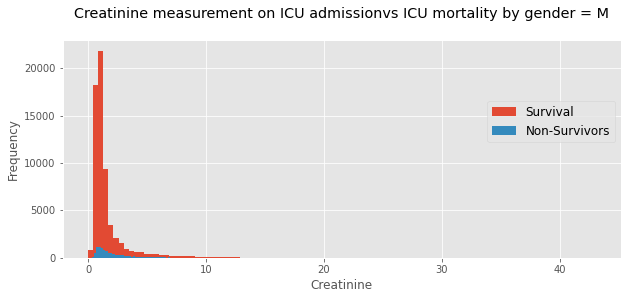

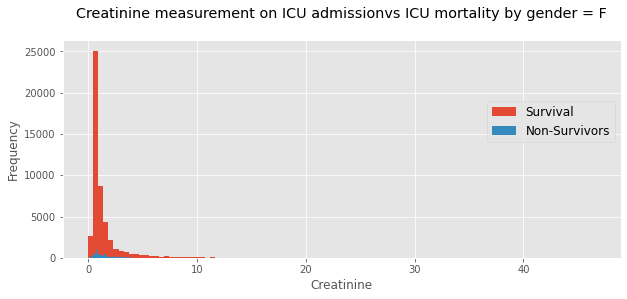

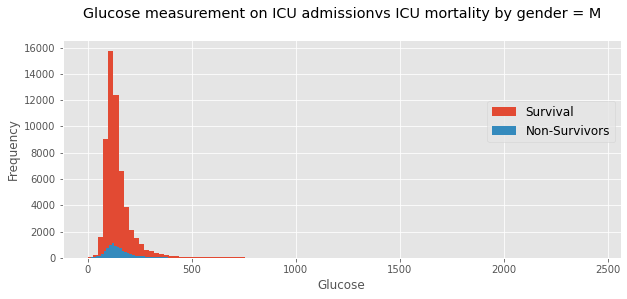

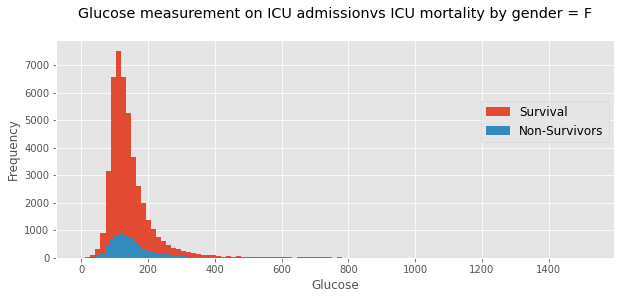

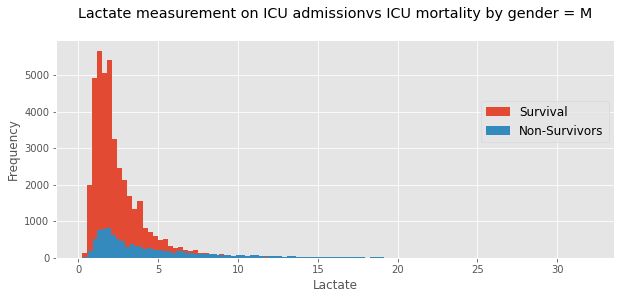

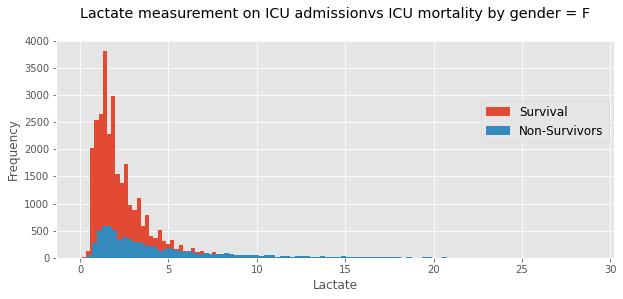

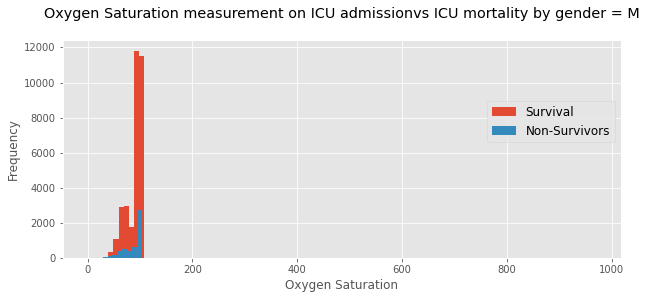

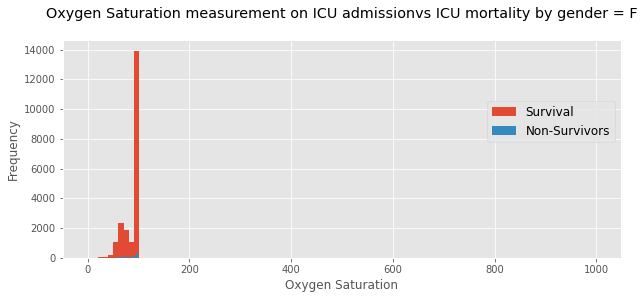

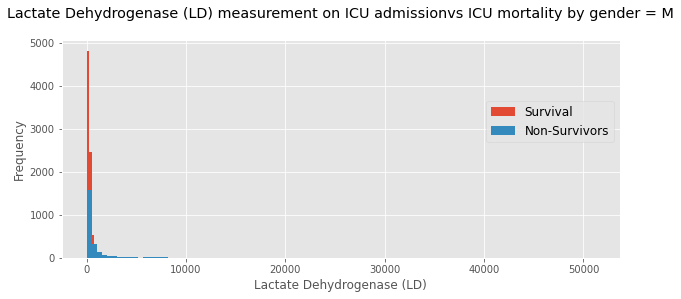

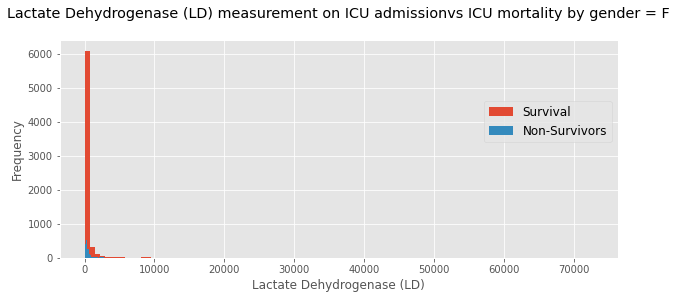

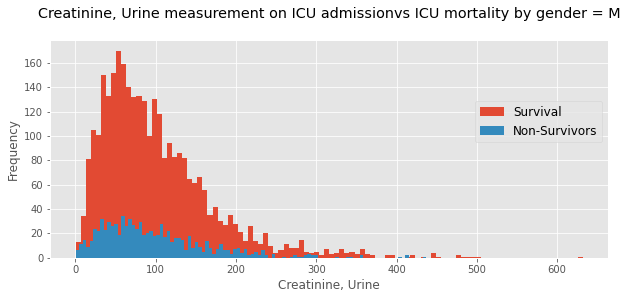

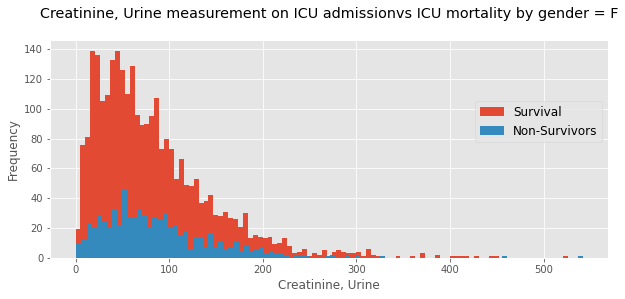

In [13]:
gender_values = ['M', 'F']

for lab_measurement in lab_measurement_types:

    for gend in gender_values:
     
        
        #print gend
        non_survivors = generate_gender_survivor_cohorts(lab_events_data_df, gend, expired=True)
        
        survivors = generate_gender_survivor_cohorts(lab_events_data_df, gend, expired=False)
        plot_gender_survivor_lab_values_distributions(survivors, non_survivors, lab_value)    

# Individual Lab Measurement Exploration

In [14]:
def visualize_lab_value_distribution(lab_values_series, xlimits=None, bins=500):
    
    fig, axes = plt.subplots(1,2, figsize=(14,4))
    lab_values_series.plot.hist(
                            ax=axes[0],
                            bins=bins, 
                            title=lab_values_series.name + ' Distribution'
    )
    if xlimits:
        axes[0].set_xlim(xlimits)
    ax = lab_values_series.plot.hist(
                            ax=axes[1],
                            bins=bins, 
                            logx=True,
                            title=lab_values_series.name + ' Log Distribution'
    
    )
    plt.xlabel("Log Scale")
   

In [15]:
def generate_lab_value_series(lab_values_df, lab_measurement):

    lab_values_series = lab_values_df[
                                    lab_values_df['label']== lab_measurement
                                    ]['valuenum']
    lab_values_series.name = lab_measurement
    return lab_values_series
    


In [16]:
def generate_histogram_frequency_counts(lab_values_series, bins=1000):
    #returns non-zero frequency counts
    count, division = np.histogram(lab_values_series.dropna(), bins=bins)
    histogram_frequency_counts_series = pd.Series(count, division[:-1])
    non_zero_histogram_frequency_counts_series = histogram_frequency_counts_series[
                                                    histogram_frequency_counts_series>0
    ]
    return non_zero_histogram_frequency_counts_series

# pH

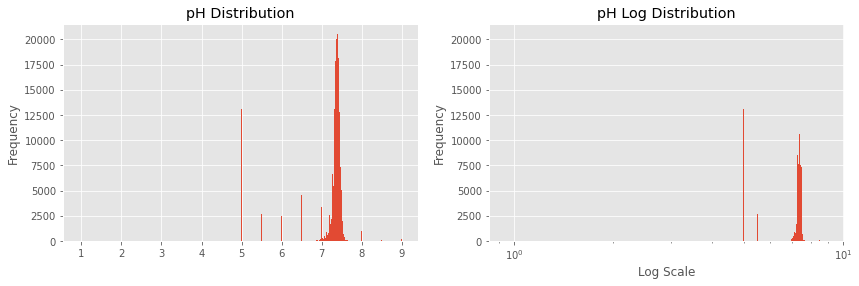

In [17]:
# Visualize raw values on normal and log scale
pH_values_series = generate_lab_value_series(lab_events_data_df, 'pH')

visualize_lab_value_distribution(pH_values_series) 

### Removing values above 8 and below 6.5
Evidence to date supports the assumption that pH values outside this range are incompatible with life. 
Values outside this range also appear to occur in whole integers which leads to the conclusion that 
these are errors and not continuous measurements. 


Normal cellular metabolism and function require that blood pH be maintained within narrow limits, 
7.35-7.45. Even mild excursion outside this range has deleterious effect, 
and pH of less than 6.8 or greater than 7.8 is considered – according to medical and physiology texts – 
incompatible with life. 
Such a view is challenged by the detail of a recently published case report, 
which describes survival of a patient whose pH was just 6.53
https://acutecaretesting.org/en/journal-scans/record-breaking-blood-ph-survival-following-extreme-acidosis

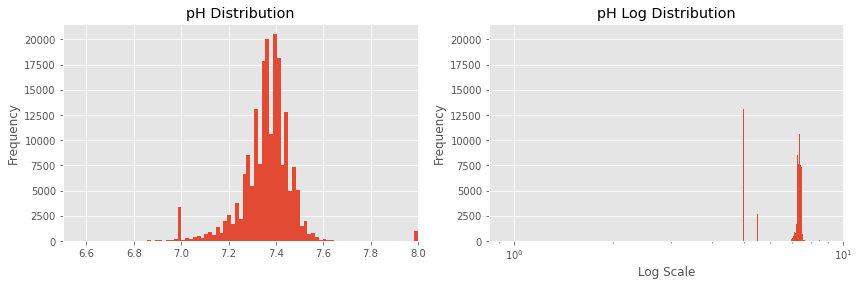

In [18]:
# Visualize raw values on a predefined scale
visualize_lab_value_distribution(pH_values_series, [6.5, 8]) 

In [19]:
ph_frequency_counts_series = generate_histogram_frequency_counts(pH_values_series, bins=1000)

# View frequency counts
print(ph_frequency_counts_series.to_string())

0.94000        1
0.99642        6
3.99474        2
4.99418    13123
5.49390     2706
5.99362     2467
6.22736        1
6.36438        1
6.38856        1
6.39662        1
6.45304        1
6.48528        1
6.49334     4606
6.52558        1
6.54976        1
6.55782        1
6.58200        1
6.60618        2
6.61424        2
6.62230        1
6.63842        1
6.64648        4
6.65454        1
6.66260        1
6.68678        2
6.69484        5
6.70290        1
6.71902        6
6.72708        5
6.73514        8
6.74320        7
6.75932        6
6.76738        7
6.77544       15
6.78350       18
6.79962       14
6.80768       25
6.81574       21
6.82380       10
6.83992       17
6.84798       22
6.85604       27
6.86410       28
6.87216       30
6.88828       41
6.89634       40
6.90440       34
6.91246       41
6.92858       41
6.93664       60
6.94470       45
6.95276       65
6.96888       64
6.97694      100
6.98500       77
6.99306     3258
7.00918      126
7.01724      137
7.02530      1

# White Blood Cells

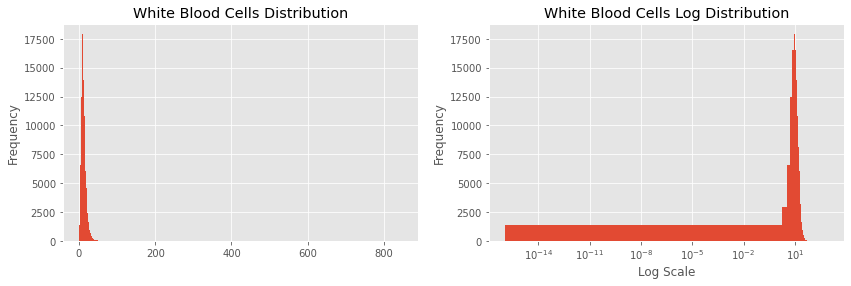

In [20]:
# Visualize raw values on normal and log scale
wbc_values_series = generate_lab_value_series(lab_events_data_df, 'White Blood Cells')

visualize_lab_value_distribution(wbc_values_series) 

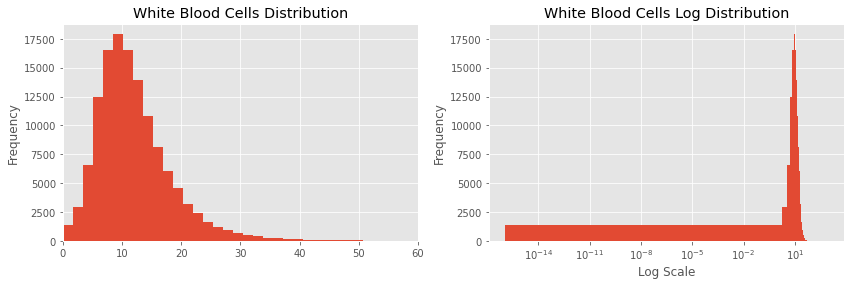

In [21]:
# Visualize raw values on a predefined scale
visualize_lab_value_distribution(wbc_values_series, [0,60]) 

In [22]:
wbc_frequency_counts_series = generate_histogram_frequency_counts(wbc_values_series, bins=1000)

# View frequency counts to see if the long tails are outliers or just very high numbers
print(wbc_frequency_counts_series.to_string())

0.0000       726
0.8467       666
1.6934      1219
2.5401      1709
3.3868      2873
4.2335      3747
5.0802      5854
5.9269      6608
6.7736      8506
7.6203      8047
8.4670      9662
9.3137      8267
10.1604     9006
11.0071     7531
11.8538     7801
12.7005     6130
13.5472     5373
14.3939     5427
15.2406     4171
16.0873     4008
16.9340     3010
17.7807     3022
18.6274     2322
19.4741     2230
20.3208     1606
21.1675     1558
22.0142     1244
22.8609     1147
23.7076      858
24.5543      829
25.4010      642
26.2477      537
27.0944      524
27.9411      420
28.7878      391
29.6345      285
30.4812      304
31.3279      247
32.1746      221
33.0213      178
33.8680      160
34.7147      133
35.5614      141
36.4081      102
37.2548      111
38.1015       90
38.9482       65
39.7949       84
40.6416       53
41.4883       57
42.3350       61
43.1817       34
44.0284       39
44.8751       31
45.7218       46
46.5685       33
47.4152       30
48.2619       39
49.1086       

I am unaware of any upper possible limit on WBC counts. 
In the absence of that, the tail appears to include a number of high measurements and does not appear to result from a single 
erroneous value. Its therefore concluded there's insufficient evidence to conclude the values are outliers 


# Creatinine

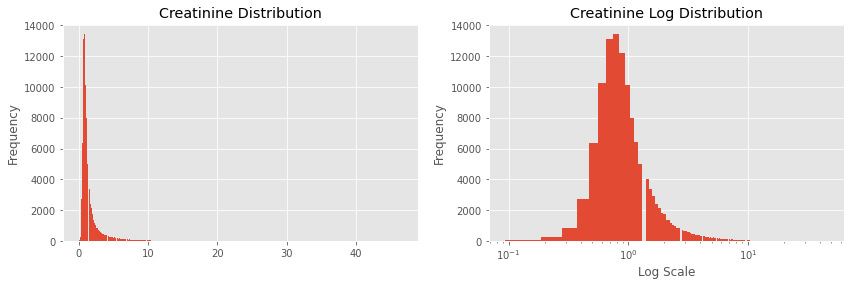

In [23]:
# Visualize raw values on normal and log scale
creatinine_values_series = generate_lab_value_series(lab_events_data_df, 'Creatinine')

visualize_lab_value_distribution(creatinine_values_series) 

### Creatinine appears to follow a log-normal distribution

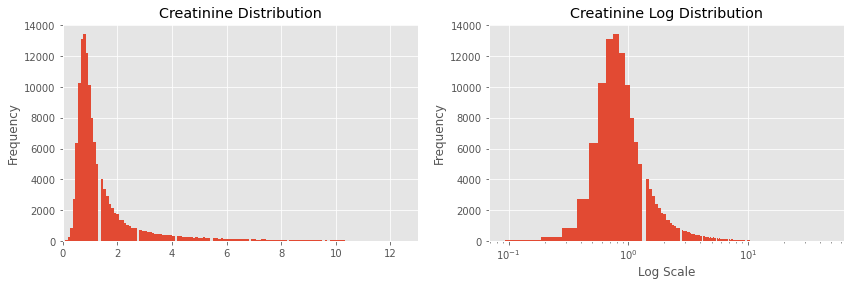

In [24]:
# Visualize raw values on a predefined scale
visualize_lab_value_distribution(creatinine_values_series, [0,13]) 

In [25]:
creatinine_frequency_counts_series = generate_histogram_frequency_counts(creatinine_values_series, bins=1000)

# View frequency counts to see if the long tails are outliers or just very high numbers
print(creatinine_frequency_counts_series.to_string())

0.0000         8
0.0932        79
0.1864       263
0.2796       861
0.3728      2744
0.4660      6342
0.5592     10271
0.6990     13116
0.7922     13450
0.8854     12213
0.9786     10134
1.0718      7986
1.1650      6429
1.2582      4972
1.3980      4052
1.4912      3408
1.5844      2905
1.6776      2381
1.7708      2114
1.8640      1847
1.9572      1735
2.0970      1387
2.1902      1375
2.2834      1147
2.3766      1070
2.4698      1005
2.5630       843
2.6562       853
2.7960       721
2.8892       629
2.9824       679
3.0756       577
3.1688       563
3.2154         1
3.2620       549
3.3552       485
3.4950       453
3.5882       459
3.6814       387
3.7746       382
3.8678       387
3.9610       368
4.0542       307
4.1940       312
4.2872       294
4.3804       257
4.4736       280
4.5668       274
4.6600       256
4.7998       226
4.8930       241
4.9862       217
5.0794       214
5.1726       239
5.2658       204
5.3590       193
5.4988       199
5.5920       182
5.6852       1

The highest peak creatinine level observed as of 2013 was 53.9. The long tail observed here is therefore
within the range of observed values. 

https://www.researchgate.net/publication/273742614_A_Surviving_Patient_with_Record_High_Creatinine#:~:text=A%20literature%20search%20indicates%20that,in%20the%20literature%20%5B3%5D%20.


# Glucose

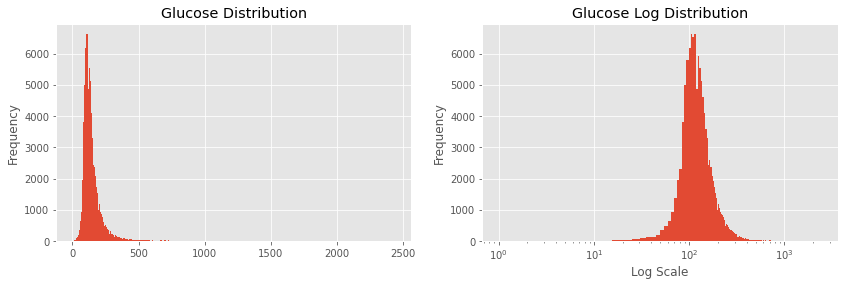

In [26]:
# Visualize raw values on normal and log scale
glucose_values_series = generate_lab_value_series(lab_events_data_df, 'Glucose')

visualize_lab_value_distribution(glucose_values_series) 

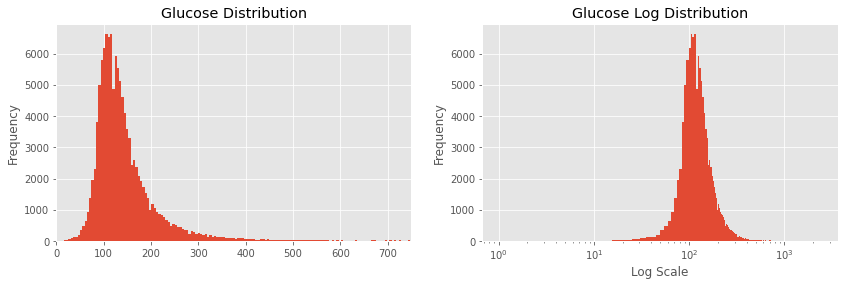

In [27]:
# Visualize raw values on a predefined scale
visualize_lab_value_distribution(glucose_values_series, [0,750]) 

### Glucose appears to follow a log-normal distribution

In [28]:
glucose_frequency_counts_series = generate_histogram_frequency_counts(glucose_values_series, bins=1000)

# View frequency counts to see if the long tails are outliers or just very high numbers
print(glucose_frequency_counts_series.to_string())

1.000          3
5.878          3
8.317          4
10.756         6
13.195         6
15.634         8
18.073        17
20.512        17
22.951        23
25.390        21
27.829        40
30.268        31
32.707        53
35.146        41
37.585        72
40.024        69
42.463        68
44.902       120
47.341        64
49.780       207
52.219       155
54.658       268
57.097       206
59.536       201
61.975       428
64.414       311
66.853       603
69.292       492
71.731       891
74.170       658
76.609      1298
79.048      1052
81.487      1239
83.926      2072
86.365      1745
88.804      2808
91.243      2191
93.682      3417
96.121      2366
98.560      2526
100.999     3669
103.438     2571
105.877     4060
108.316     2709
110.755     3838
113.194     2681
115.633     3936
118.072     2459
120.511     2408
122.950     3539
125.389     2383
127.828     3376
130.267     2153
132.706     3131
135.145     1979
137.584     2795
140.023     1828
142.462     1658
144.901     24

The highest recorded blood glucose measurement as of 2001 was 2,656. 
The long tail observed here is therefore within the range of observed values. 

Michael Patrick Buonocore (USA) (b. 19 May 2001), survived a blood sugar level of 147.6 mmol/L (2,656 mg/dl) when admitted 
to the Pocono Emergency Room in East Stroudsburg, Pennsylvania, USA, on 23 March 2008. The normal blood sugar range is 
between 4.4 to 6.6 mmol/L (80-120 mg/dl).

https://www.guinnessworldrecords.com/world-records/highest-blood-sugar-level/?fb_comment_id=811257658947726_974655159274641#:~:text=Michael%20Patrick%20Buonocore%20(USA)%20(,%2D120%20mg%2Fdl).

# Lactate 

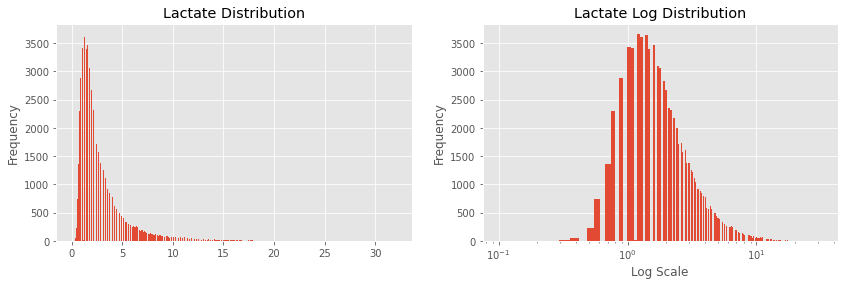

In [29]:
# Visualize raw values on normal and log scale
lactate_values_series = generate_lab_value_series(lab_events_data_df, 'Lactate')

visualize_lab_value_distribution(lactate_values_series) 

### Lactate appears to follow a log-normal distribution

# Oxygen Saturation

In [30]:
lab_measurement_types

['pH',
 'Hematocrit',
 'White Blood Cells',
 'Creatinine',
 'Glucose',
 'Lactate',
 'Oxygen Saturation',
 'Lactate Dehydrogenase (LD)',
 'Creatinine, Urine']

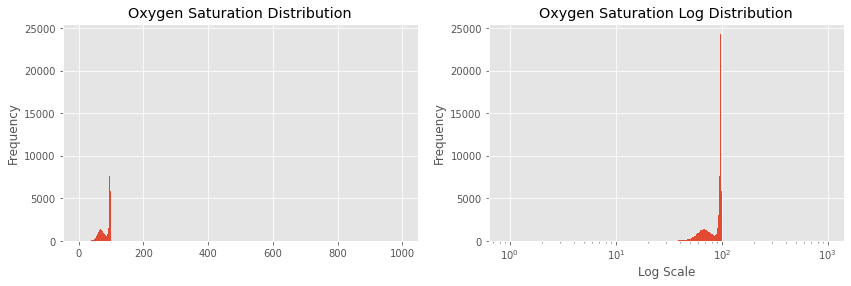

In [31]:
# Visualize raw values on normal and log scale
oxygen_values_series = generate_lab_value_series(lab_events_data_df, 'Oxygen Saturation')

visualize_lab_value_distribution(oxygen_values_series) 

In [32]:
### Oxygen Saturation is a percent value and can't be above 100

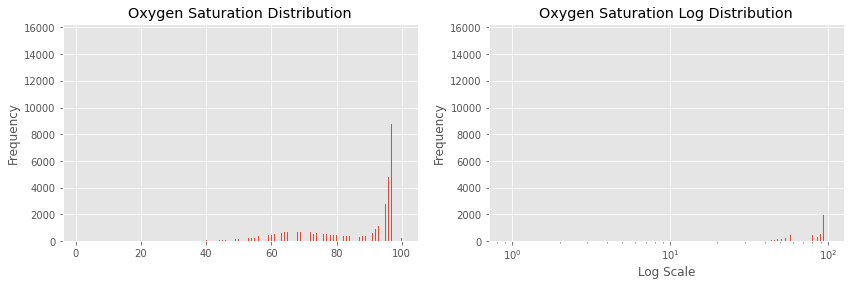

In [33]:
# Visualize raw values on a predefined scale
oxygen_values_series = oxygen_values_series[oxygen_values_series<=100]
visualize_lab_value_distribution(oxygen_values_series) 

### Glucose appears to follow a non-normal distribution

In [34]:
oxygen_frequency_counts_series = generate_histogram_frequency_counts(oxygen_values_series, bins=100)

# View frequency counts to see if the long tails are outliers or just very high numbers
print(oxygen_frequency_counts_series.to_string())

0.900         8
2.882         1
3.873         1
4.864         1
5.855         1
7.837         1
8.828         3
10.810        1
12.792        1
14.774        3
16.756        3
17.747        1
18.738        4
19.729        4
20.720        2
21.711        5
22.702        5
23.693        3
24.684        7
25.675        5
26.666       12
27.657       11
28.648        5
29.639       11
30.630       11
31.621       20
32.612       16
33.603       24
34.594       15
35.585       18
36.576       20
37.567       20
38.558       37
39.549       40
40.540       33
41.531       36
42.522       60
43.513       73
44.504       76
45.495       66
46.486       78
47.477      114
48.468      119
49.459      130
50.450      158
51.441      190
52.432      220
53.423      240
54.414      255
55.405      348
56.396      340
57.387      425
58.378      430
59.369      478
60.360      499
61.351      517
62.342      589
63.333      661
64.324      637
65.315      686
66.306      713
67.297      674
68.288  

### Lactate Dehydrogenase (LD)

In [35]:
lab_measurement_types

['pH',
 'Hematocrit',
 'White Blood Cells',
 'Creatinine',
 'Glucose',
 'Lactate',
 'Oxygen Saturation',
 'Lactate Dehydrogenase (LD)',
 'Creatinine, Urine']

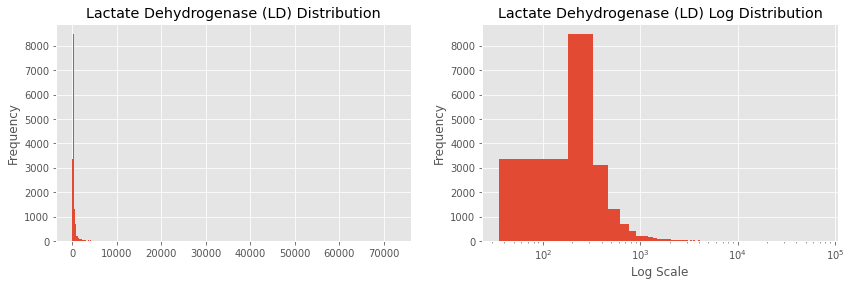

In [36]:
# Visualize raw values on normal and log scale
ld_values_series = generate_lab_value_series(lab_events_data_df, 'Lactate Dehydrogenase (LD)')

visualize_lab_value_distribution(ld_values_series) 

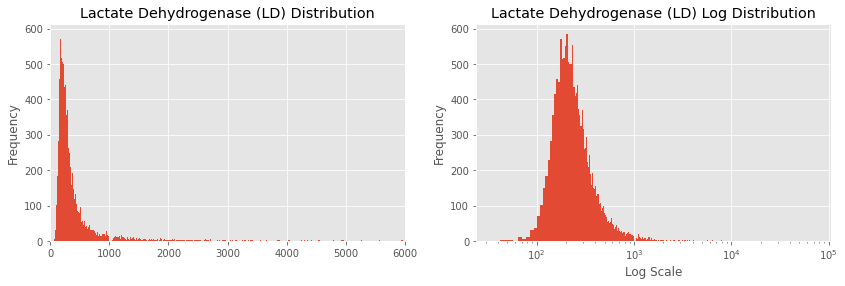

In [37]:
# Visualize raw values on normal and log scale
ld_values_series = generate_lab_value_series(aggregate_lab_values_for_visualization_df, 'Lactate Dehydrogenase (LD)')

visualize_lab_value_distribution(ld_values_series, [0,6000], bins=10000) 

### Lactate Dehydrogenase appears to follow a Log-Normal distribution

In [38]:
ld_frequency_counts_series = generate_histogram_frequency_counts(ld_values_series, bins=100)

# View frequency counts to see if the long tails are outliers or just very high numbers
print(ld_frequency_counts_series.to_string())

35.00       16984
760.52       1133
1486.04       374
2211.56       199
2937.08       107
3662.60        91
4388.12        72
5113.64        44
5839.16        34
6564.68        39
7290.20        36
8015.72        30
8741.24        24
9466.76        16
10192.28       10
10917.80       10
11643.32        8
12368.84        6
13094.36        4
13819.88        6
14545.40        5
15270.92        1
15996.44        3
16721.96        4
18173.00        1
19624.04        2
20349.56        2
21800.60        1
22526.12        3
23977.16        3
26153.72        2
32683.40        1
39938.60        1
42115.16        1
50821.40        1
71861.48        1


# Creatinine, Urine

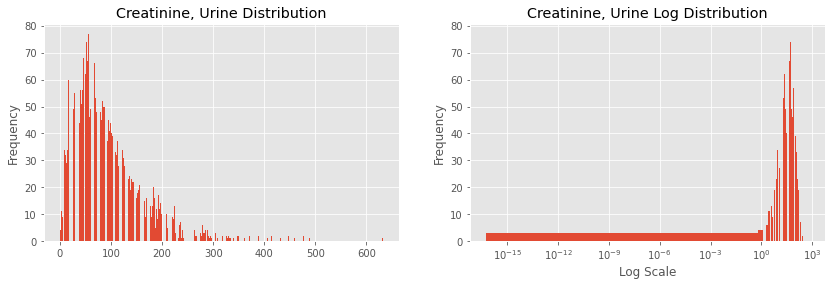

In [39]:
# Visualize raw values on normal and log scale
urine_creatinine_values_series = generate_lab_value_series(lab_events_data_df, 'Creatinine, Urine')

visualize_lab_value_distribution(urine_creatinine_values_series, bins=1000) 

### Urine Creatinine appears to follow a right-skewed normal distribution

In [40]:
urine_creatinine_frequency_counts_series = generate_histogram_frequency_counts(urine_creatinine_values_series, bins=100)

# View frequency counts to see if the long tails are outliers or just very high numbers
print(urine_creatinine_frequency_counts_series.to_string())

0.00       65
6.32      162
12.64     228
18.96     361
25.28     287
31.60     335
37.92     394
44.24     369
50.56     400
56.88     392
63.20     326
69.52     311
75.84     317
82.16     307
88.48     252
94.80     294
101.12    243
107.44    205
113.76    213
120.08    166
126.40    184
132.72    161
139.04    142
145.36    124
151.68    117
158.00    121
164.32     94
170.64     71
176.96     99
183.28     57
189.60     59
195.92     64
202.24     53
208.56     39
214.88     45
221.20     36
227.52     21
233.84     34
240.16     19
246.48      8
252.80     10
259.12     16
265.44     13
271.76     16
278.08     21
284.40     15
290.72     12
297.04      9
303.36      6
309.68     13
316.00      6
322.32      6
328.64      6
334.96      6
341.28      7
347.60      3
353.92     10
360.24      3
366.56      5
385.52      4
391.84      2
398.16      1
404.48      2
410.80      5
417.12      2
423.44      1
429.76      1
436.08      1
442.40      6
448.72      1
455.04      1
474.00

In [41]:
aggregate_lab_values_for_visualization[
    aggregate_lab_values_for_visualization[lab_label]== 'Glucose'
    
][lab_valuenum].describe()


NameError: name 'aggregate_lab_values_for_visualization' is not defined

In [ ]:
aggregate_lab_values_for_visualization[
    (aggregate_lab_values_for_visualization[lab_label]== 'Glucose') #&
#      (aggregate_lab_values_for_visualization[lab_value]>1000)
    
][lab_value].plot.hist(bins=100)


In [ ]:
aggregate_lab_values_for_visualization[
    (aggregate_lab_values_for_visualization[lab_label]== 'Glucose')&
    (aggregate_lab_values_for_visualization[lab_value]>1000)
    
][lab_value].describe()


### DEBUG STOP

## Reorganizing the data
The imported data uses subject_id as the index. The following code moves the subject_id data to a column, creates
a proper index and reorganizes the columns to have the lab results grouped together. 

In [ ]:
# print("loading lab data")
# lab_events_data_df['subject_id'] = lab_events_data_df.index
# lab_events_data_df.set_index(np.arange(lab_events_data_df.shape[0]), inplace = True)
# cols = list(lab_events_data_df.columns)
# cols.insert(0, cols.pop(cols.index('icustay_id')))
# cols.insert(1, cols.pop(cols.index('subject_id')))
# lab_events_data_df = lab_events_data_df[cols]
# print("complete")

In [ ]:
unique_icu_stay_count = lab_events_data_df.drop_duplicates('icustay_id', keep = 'first').shape[0]
unique_patients_count = lab_events_data_df.drop_duplicates('subject_id', keep = 'first').shape[0]

print("The number of unique ICU stays = {}".format(unique_icu_stay_count))
print("The number of unique patients  = {}\n".format(unique_patients_count))

# display the different measurements captured in the database query
labels = lab_events_data_df.label.unique()
print("Lab measurements inlcude/n")
print(labels)
# display(lab_events_data_df.shape)
print("Example lab values for Lactate:")
display(lab_events_data_df[(lab_events_data_df.label=='Lactate') & (~(lab_events_data_df.valuenum.isnull()))].head())



## Assessing Feature Prevalence


# DEBUG START 

In [ ]:
test_merged_pivot_df.head()

In [ ]:
test_merged_pivot_df[~test_merged_pivot_df['Hematocrit'].isna()][['icustay_id','Hematocrit']].groupby('icustay_id').first()


# DEBUG STOP

In [ ]:
# REMOVE VARIABLES FOR WHICH THERE IS LITTLE DATA / FEW ICUSTAYS FOR WHICH DATA WAS RECORDED
labels2 = []

for item in labels:
    lab_count = lab_events_data_df['icustay_id'][lab_events_data_df['label'] == item].dropna().unique().shape[0]
    #num_measures = data[data.label == item][['icustay_id', 'label']].dropna().groupby('icustay_id').count()
    print("{}    {}".format(item, lab_count)) #, num_measures)
    if lab_count > 6000:
        print("adding {}".format(item))
        labels2.append(item)
labels2.sort(key=str.lower)
labels2

## CALCULATE NUMBER OF SAMPLES FOR EACH FEATURE

In [ ]:
labels2[0]

In [ ]:
# calculating the number of samples taken in 24 hours for each measurement
item = labels2[0]

lab_counts_df =  lab_events_data_df[lab_events_data_df['label'] == item][['icustay_id', 'label']].dropna().groupby('icustay_id').count()
   
for item in labels2[1:]:
    #num_samps = data['icustay_id'][data.label == item].dropna().unique().shape[0]
    groupby_counts = lab_events_data_df[lab_events_data_df['label'] == item][['icustay_id', 'label']].dropna().groupby('icustay_id').count()
    groupby_counts.columns = [item]
    lab_counts_df = lab_counts_df.merge(groupby_counts,left_index = True, right_index = True, how = 'left', sort = True) 
    #print "{}    {}".format(item, num_measures) #, num_measures)

#num_samps_df.drop('label', axis=1, inplace = True)
lab_counts_df.dropna().head(20)

## GENERATE COLORMAPS SHOWING PATTERNS OF MISSING DATA 

In [ ]:
# DISPLAY COLORMAP OF MISSING SAMPLES FOR EACH VARIABLE
# REFERRING TO THIS AS AN AFFINITY MAP, SHOWING WHICH DATA WAS COLLECTED MOST OFTEN TOGETHER. 
# ASSIGNING NaN A POSITIVE VALUE MAKES MISSING DATA APPEAR BRIGHT YELLOW

lab_count_map_df = lab_counts_df.copy()
lab_count_map_df.drop(['label'], axis=1, inplace=True)
for col in lab_count_map_df.columns:
        lab_count_map_df[col] = lab_count_map_df[col].apply(lambda x: 1 if pd.isnull(x) else 0)
        

# lab_count_map_df = lab_count_map_df.sort_values(by ='Oxygen Saturation', axis = 0, ascending = True)
plt.rc('font', size=15)   
plt.figure(figsize= (25,15))
plt.pcolor(lab_count_map_df)
#ax.set_ylim([0.0,missing.shape[0]])


plt.xticks(np.arange(0.5, len(lab_count_map_df.columns), 1), lab_count_map_df.columns)
plt.xticks(rotation = 30, ha = 'right')

plt.show()
plt.close()

In [ ]:
lab_events_data_df

## Feature Engineering
Calculating values from original data including mean, std, delta etc. 


In [ ]:
labels2

In [ ]:
# height and weight are left out from the calculated measures because there was only one
# measurement so they are constant.

# creates dicts of new feature names with the lab label as entries
# this will help in traversing columns and calculating new features

# labels2 were sorted alphabetically so we order this list accordingly before zipping
dict_names = ['Creat','CreatUrine', 'Gluc', 'Hemat', 'Lac', 'LacDehyd', 'O2sat', 'pH', 'WBC']

first_dict_names = dict(zip([item + '_first' for item in dict_names], labels2))
mean_dict_names = dict(zip([item + '_mean' for item in dict_names], labels2))
med_dict_names = dict(zip([item + '_med' for item in dict_names], labels2))
std_dict_names = dict(zip([item + '_std' for item in dict_names], labels2))
skew_dict_names = dict(zip([item + '_skew' for item in dict_names], labels2))
min_dict_names = dict(zip([item + '_min' for item in dict_names], labels2))
max_dict_names = dict(zip([item + '_max' for item in dict_names], labels2))
slope_dict_names = dict(zip([item + '_slope' for item in dict_names], labels2))
delta_dict_names = dict(zip([item + '_delta' for item in dict_names], labels2))
abnflag_dict_names = dict(zip([item + '_abnflag' for item in dict_names], labels2))

In [ ]:
first_dict_names

In [ ]:
# creates list of name_dicts
names_list = [first_dict_names, mean_dict_names, med_dict_names, std_dict_names, skew_dict_names, 
              min_dict_names, max_dict_names, slope_dict_names, delta_dict_names, abnflag_dict_names ]
# create list of zipping into dictionary the measurement type and 
# corresponding names dict 
calc_list = ['first', 'mean', 'med', 'std', 'skew', 'min', 'max', 'slope', 'delta', 'abnflag']

# create dictionary where the key is the feature type (calculation
# and the value is the appropriate names dicts
names_dict = dict(zip(calc_list, names_list))


# CREATE DICTIONARIES IN WHICH TO STORE CALCULATED VALUES
first_dict = {}
mean_dict = {}
med_dict = {}
std_dict = {}
skew_dict = {}
kurt_dict = {}
min_dict = {}
max_dict = {}
slope_dict = {}
delta_dict = {}
abnflag_dict = {}
dict_list = [first_dict, mean_dict, med_dict, std_dict, skew_dict, min_dict, max_dict, slope_dict, delta_dict,
            abnflag_dict]
calc_dict = dict(zip(calc_list, dict_list))

In [ ]:
calc_dict

In [ ]:
# iterating through the lab measurements for each ICU stay, calculating means, medians, std, skewness min and max
# lab measurements within an ICU stay with too few measurements to calculate feature will be assigned NaN values

print("Creating data frames for each summary statistic for each time course variable")
for calc_key in calc_dict.keys():
    for col_key in names_dict[calc_key].keys(): 
        if calc_key == 'mean':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].mean())
        elif calc_key == 'med':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].median())
        elif calc_key == 'std':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].std())
        elif calc_key == 'max':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].max())
        elif calc_key == 'min':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].min())
        elif calc_key == 'first': 
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].first())
        elif calc_key == 'skew':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].skew())
        elif calc_key == 'delta': 
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].last() -
                                                        lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].first())
        elif calc_key == 'abnflag':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['flag'].apply(lambda x: int(1) if 'abnormal' in x.values else int(0)))
              
        elif calc_key == 'slope':
            time_last = lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['charttime'].last()
            time_first = lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['charttime'].first()
            val_last = lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].last()
            val_first = lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].first()
            calc_dict[calc_key][col_key] = pd.DataFrame((val_last - val_first)/((time_last - time_first)/np.timedelta64(1,'h')))           
        
            
        else: 
            print("need to add code for calculating {}".format(calc_key))
            break
            
        calc_dict[calc_key][col_key].replace([np.inf, -np.inf], np.nan, inplace = True)
        calc_dict[calc_key][col_key].columns = [col_key]
        calc_dict[calc_key][col_key]['hospital_expire_flag'] = lab_events_data_df.groupby('icustay_id').hospital_expire_flag.first()
        calc_dict[calc_key][col_key]['gender'] = lab_events_data_df.groupby('icustay_id').gender.first()

print("complete")

## PLOTTING DATA

In [ ]:
# PLOTTING DATA FOR EXAMPLE FRAME
#mean_dict[mean_dict.keys()[0]].head()
dummy = calc_dict['mean']

for col in dummy.keys():
    
    col2 = dummy[col].columns[0]
    
    
    gender = ['M', 'F'] 
    
    for gend in gender:
        
        #print gend
        dead = dummy[col][(dummy[col].hospital_expire_flag == 1)&
                              (dummy[col].gender == gend)]
                          #&(const_dict[col][col2] >20)]
        dead.name = 'Non_Survivors'
        live = dummy[col][(dummy[col].hospital_expire_flag == 0)&
                              (dummy[col].gender == gend)]
                          #&(const_dict[col][col2] >20)]
        live.name = 'Survivors'
    
    
    
    
    
    #dummy = mean_dict[key][mean_dict[key].gender == 'F']
    #dummy = skew_dict[key].merge(pd.DataFrame(ptnt_demog['hospital_expire_flag']), 
    #                                   left_index = True, right_index = True, how='left', sort = True)
    
        maxx = 0.99
        minn = 0.01
    
        live_max = live[col2].dropna().max()#quantile(0.999)
        live_min = live[col2].dropna().min()#quantile(0.001)
        dead_max = dead[col2].dropna().max()#quantile(0.999)
        dead_min = dead[col2].dropna().min()#quantile(0.001)
        maxlim = max(live_max, dead_max)
        minlim = min(live_min, dead_min)
   
        
        plt.subplots(figsize=(10,4))
        live[(live[col2] < live_max) & (live[col2] > live_min)][col2].plot.kde(
                                                                            alpha=1.0,label='Survival')
    
        dead[(dead[col2] < dead_max) & (dead[col2] > dead_min)][col2].plot.kde(
                                                                            alpha=1.0,label='Non-Survivors')
        # add title, labels etc.
        plt.title('{} measurement on ICU admission'.format(col) + 
                   'vs ICU mortality by gender = {}\n'.format(gend))
        plt.xlabel(col)
        plt.legend(loc="upper left", bbox_to_anchor=(.75,.75),fontsize=12)
   
    
        #print "{}    {}".format(maxlim, minlim)
        plt.xlim(minlim, maxlim)

## REMOVE OUTLIER DATA POINTS 

In [ ]:
# 

names_dict = {}
suffix = '_outliers'

# SETTING OUTLIER DATA POINTS TO NAN FOR REMOVAL USING DROPNA()
for calc in calc_dict.keys():
    frame = calc_dict[calc]
    for col in frame.keys():
    # plot
    # print col
        dummy = frame[col]
        col2 = dummy.columns[0]
        #print "{}   {}     {}".format(col, col2, dummy.dropna().shape)
        Q1 = np.percentile(dummy[col2].dropna(), 25)
        # TODO: Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(dummy[col2].dropna(), 75)
        # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = 1.5*(Q3 - Q1)
        names_dict[col+suffix] = dummy[~((dummy[col2] >= Q1 - step) & (dummy[col2] <= Q3 + step))].index
#         dummy.set_value(names_dict[col+suffix], col2, np.NaN)
#         dummy.set_value(names_dict[col+suffix], col2, np.NaN)
        dummy.loc[names_dict[col+suffix], col2] = np.NaN
        #print "{}   {}     {}".format(col, col2, dummy.dropna().shape)




In [ ]:
names_dict[col+suffix]

In [ ]:
dummy

## PLOT DATA WITH OUTLIERS REMOVED

In [ ]:
# PLOTTING DATA FOR EXAMPLE FRAME
#mean_dict[mean_dict.keys()[0]].head()
dummy = calc_dict['min']

for col in dummy.keys():
    
    col2 = dummy[col].columns[0]
    
    
    gender = ['M', 'F'] 
    
    for gend in gender:
        
        #print gend
        dead = dummy[col][(dummy[col].hospital_expire_flag == 1)&
                              (dummy[col].gender == gend)]
                          #&(const_dict[col][col2] >20)]
        dead.name = 'Non_Survivors'
        live = dummy[col][(dummy[col].hospital_expire_flag == 0)&
                              (dummy[col].gender == gend)]
                          #&(const_dict[col][col2] >20)]
        live.name = 'Survivors'
    
    
    
    
    #dummy = mean_dict[key][mean_dict[key].gender == 'F']
    #dummy = skew_dict[key].merge(pd.DataFrame(ptnt_demog['hospital_expire_flag']), 
    #                                   left_index = True, right_index = True, how='left', sort = True)
    
        maxx = 0.99
        minn = 0.01
    
        live_max = live[col2].dropna().max()#quantile(0.999)
        live_min = live[col2].dropna().min()#quantile(0.001)
        dead_max = dead[col2].dropna().max()#quantile(0.999)
        dead_min = dead[col2].dropna().min()#quantile(0.001)
        maxlim = max(live_max, dead_max)
        minlim = min(live_min, dead_min)
   
        
        plt.subplots(figsize=(10,4))
        live[(live[col2] < live_max) & (live[col2] > live_min)][col2].plot.kde(
                                                                            alpha=1.0,label='Survival')
    
        dead[(dead[col2] < dead_max) & (dead[col2] > dead_min)][col2].plot.kde(
                                                                            alpha=1.0,label='Non-Survivors')
        # add title, labels etc.
        plt.title('{} measurement on ICU admission'.format(col) + 
                   'vs ICU mortality by gender = {}\n'.format(gend))
        plt.xlabel(col)
        plt.legend(loc="upper left", bbox_to_anchor=(0.75,0.75),fontsize=12)
   
    
        #print "{}    {}".format(maxlim, minlim)
        #plt.xlim(minlim, maxlim)

## MERGE INDIVIDUAL DATAFRAMES INTO SINGLE FRAME

In [ ]:
# MERGING INDIVIDUAL CALCULATED FRAMES INTO A SINGLE DATAFRAMEs
lab_events_data_df2 = lab_events_data_df.drop_duplicates('icustay_id', keep = 'first')
lab_events_data_df3 = lab_events_data_df2.drop(['label', 'charttime', 'valuenum', 'flag'], axis = 1)
lab_events_data_df3.set_index(['icustay_id'], inplace = True)

for calc_key in calc_dict.keys():
    print("merging {} dataframe".format(calc_key))
    for col_key in calc_dict[calc_key].keys(): 
        col2 = calc_dict[calc_key][col_key]
        lab_events_data_df3 = lab_events_data_df3.merge(pd.DataFrame(calc_dict[calc_key][col_key][col_key]), left_index = True, 
                           right_index = True, how = 'left', sort = True)
        newcols = list(lab_events_data_df3.columns)
        newcols.pop()
        newcols.append(col_key)
        lab_events_data_df3.columns = newcols
display(lab_events_data_df3.shape)
display(lab_events_data_df3.head())
display(lab_events_data_df3.dtypes)
        
# OLD CODE


In [ ]:
lab_events_data_df3.columns

In [ ]:
calc

In [ ]:
[x for x in lab_events_data_df3.columns if calc in x] 

In [ ]:
lab_events_data_df3.columns

In [ ]:
boolean_cols = [
    
    
]

In [ ]:
lab_events_data_df3['Creat_abnflag'].head(25).fillna(0).astype(int)

In [ ]:
lab_events_data_df3['Creat_abnflag'].head(25).apply(lambda x: 1 if x==1.0 else 0)

# Convert Boolean Cols to INT

In [ ]:
cols = [x for x in lab_events_data_df3.columns if calc in x]
for col in cols: 
    lab_events_data_df3[col] = lab_events_data_df3[col].fillna(0).astype(int)

# Prior Versions Didn't Fully Leverage Interpolation
As Such, efforts below were made to found labs most commonly found together. 

## Looking for labs that are commonly missing together

In [ ]:
# # ROUNDING DATA
# np.set_printoptions(precision=2)

# cols = [x for x in lab_events_data_df3.columns if calc in x] 
# cols.sort()
    
# header = lab_events_data_df3[cols]
# for col in header.columns:
#     header[col] = header[col].apply(lambda x: 1 if pd.isnull(x) else 0)
# display(lab_events_data_df3[cols].dropna().shape[0])

# display(header.corr().round(2))

## DISPLAY COLORMAP OF MISSING DATA

In [ ]:
# commenting out for refinement. 
# very time consuming part of pre-processing. uncomment and run if you'd like to see the process. 


'''
# DISPLAY COLORMAP OF DATA 

for calc in calc_list:
    plt.figure(figsize= (30,30))
    cols = [x for x in data3.columns if calc in x] 
    cols.sort()
    
    header = data3[cols]
    for col in header.columns:
        max_val = -1000 #header[col].max()*100
        #header[col].replace(np.nan, max_val, inplace = True)
        header[col] = header[col].apply(lambda x: 1 if pd.isnull(x) else 0)
    display(data3[cols].dropna().shape[0])
    missing = header.corr()
    display(missing[missing >= 0.4])
    plt.pcolor(header)
    plt.xticks(np.arange(0.5, len(header.columns), 1), header.columns)
    plt.show()

print "Complete"
'''

## CREATE AUTOCORRELATION MATRIX FOR MISSING DATA

In [ ]:
# #header.apply(lambda col: col.autocorr(lag = 1), axis = 0)
# # REPLACING NAN VALUES WITH 1 AND MEASUREMENTS WITH 0. PERFORMING CORRELATION BETWEEN COLUMNS TO DETERMINE WHICH 
# # VARIABLES ARE MOST LIKELY TO BE MISSING TOGETHER. THIS WILL HELP IN BLOCKING DATA FOR PROCESSES THAT REQUIRE DATA TO 
# # BE NAN FREE
# missing = lab_events_data_df3.copy()
# for col in missing.columns:
#     missing[col] = missing[col].apply(lambda x: 1 if pd.isnull(x) else 0)
        
# monkey = missing.corr()
# monkey[monkey >= 0.4]

In [ ]:
# DROPPING COLUMNS WHERE DATA IS SPARSE AND MISSING DATA DOES NOT CORRELATE WITH OTHER VARIABLES. 
# THESE DETERMINATIONS WERE MADE THROUGH OBSERVATIONS OF THE AFFINITY MAPS AND DROPNA().SHAPE[0] VALUES ABOVE 

# REMOVING ALL CREATURINE MEASURES
drop_cols = []
for item in lab_events_data_df3.columns: 
    if (('CreatUrine'in item) | ('LacDehyd' in item) | ('_skew' in item)):
        drop_cols.append(item)
#drop_cols

# DROP THE FOLLOWING MEASURES OF THE FOLLOWING VARIABLES
#drop_names = ['CreatUrine', 'LacDehyd', 'O2sat', 'Lac']
drop_names = ['O2sat', 'Lac']
drop_measures = ['_std', '_slope']
for name in drop_names:
    for ext in drop_measures:
        drop_cols.append(name + ext)
        
drop_cols
        

display(lab_events_data_df3.dropna().shape[0])
lab_events_data_df4 = lab_events_data_df3.drop(drop_cols, inplace = False, axis = 1)
display(lab_events_data_df4.dropna().shape[0])

print("Complete")

## COMBINING FRAMES AND DROPPING MISSING VALUES

In [ ]:
# # TO THIS POINT THE ICUSTAY_ID HAS BEEN USED AS THE INDEX OF THE DATAFRAME. 
# # TO USE THESE METHODS WE CREATE A PROPER INDEX


# # BREAKING UP VARIABLES SO THAT WE CAN DROP NAN VALUES AND STILL HAVE SUFFICIENT SAMPLES 
# # TO TRANSFORM AND DO FEATURE SELECTION / SCORING
# # WILL NEED TO MERGE LATER IN A WAY THAT PROVIDES ADEQUATE SAMPLES

# cols1 = [x for x in data4.columns if (('abnflag' not in x) & (('pH' in x) | ('Lac' in x) | ('O2sat' in x)))]
# cols2 = [x for x in data4.columns if (('abnflag' not in x) & (('Creat' in x) | ('Gluc' in x) | ('Hemat' in x) | ('WBC' in x)))]
# cols3 = [x for x in data4.columns if ('abnflag' in x)]

# header = ['hospital_expire_flag']
# for thing in header:
#     cols1.insert(0, thing)
#     cols2.insert(0, thing) 
#     cols3.insert(0, thing)
  

# #display(cols1)
# data4.replace([np.inf, -np.inf], np.nan, inplace = True)
# pHLacO2Sat_data = data4[cols1].dropna()
# print "pHLacO2Sat_data: Shape = "
# display(pHLacO2Sat_data.shape)                              

# CreatGlucHemWBC_data = data4[cols2].dropna()
# print "CreatGlucHemWBC_data: Shape = "
# display(CreatGlucHemWBC_data.shape)

# AbnFlag_data = data4[cols3].dropna()
# print "AbnFlag_data: Shape = "
# display(AbnFlag_data.shape)

       
# cont_frames = [pHLacO2Sat_data, CreatGlucHemWBC_data]
# cat_frames = [AbnFlag_data]




In [ ]:
lab_events_data_df4.replace([np.inf, -np.inf], np.nan, inplace = True)

In [ ]:
lab_events_data_df4.columns

In [ ]:
X = lab_events_data_df4[lab_events_data_df4.columns[3:]]
# imp_iter = IterativeImputer(missing_values = np.nan, max_iter=100, add_indicator=True)
imp_iter = SimpleImputer(missing_values = np.nan, add_indicator=False)
imp_iter.fit(X)
imputed_data_df = imp_iter.transform(X)


In [ ]:
imputed_data_df.shape

In [ ]:
lab_events_data_df4[lab_events_data_df4.columns[3:]] = imputed_data_df


## CONVERTING CONTINUOUS TO CATEGORICAL VARIABLES

In [ ]:
lab_events_data_df4.columns

In [ ]:
# CALCULATING THE QUARTILES ON THE DISTRIBUTIONS AND BINNING DATA INTO 4 BUCKETS
# TO CONVERT CONTINUOUS VARIABLES TO CATEGORICAL

def quant_cats(feature, Q1, Q2, Q3):
    if feature <=Q1:
        return 'Q0'
    elif (feature >Q1 and feature <= Q2):
        return 'Q1'
    elif (feature > Q2 and feature <= Q3):
        return 'Q2'
    elif feature > Q3:
        return 'Q3'
    
#cont_frames = [pHLacO2Sat_data, CreatGlucHemWBC_data]
#cat_frames = [AbnFlag_data]
    
CreatGlucHemWBC_cat_data = CreatGlucHemWBC_data.copy()
pHLacO2Sat_cat_data = pHLacO2Sat_data.copy()

cont_cat_frames = [CreatGlucHemWBC_cat_data, pHLacO2Sat_cat_data]

for frame in cont_cat_frames:
    frame_stats = frame.describe()
    for col in frame.columns[1:]:
        Q1 = frame_stats[col].loc['25%']
        Q2 = frame_stats[col].loc['50%']
        Q3 = frame_stats[col].loc['75%']
        frame[col] = frame[col].apply(lambda x: quant_cats(x, Q1, Q2, Q3))

pHLacO2Sat_cat_data.head()        




## COMBINING FRAMES

In [ ]:

cont_cat_frames = [CreatGlucHemWBC_cat_data, pHLacO2Sat_cat_data]


pHLacO2Sat_dummies = pHLacO2Sat_cat_data[pHLacO2Sat_cat_data.columns[:1]].merge(pd.get_dummies(pHLacO2Sat_cat_data[pHLacO2Sat_cat_data.columns[3:]]), left_index = True, right_index = True, 
                       how = 'left', sort = True)
CreatGlucHemWBC_dummies = CreatGlucHemWBC_cat_data[CreatGlucHemWBC_cat_data.columns[:1]].merge(pd.get_dummies(CreatGlucHemWBC_cat_data[CreatGlucHemWBC_cat_data.columns[3:]]), left_index = True, right_index = True, 
                       how = 'left', sort = True)
                       
display(pHLacO2Sat_dummies.head())
display(CreatGlucHemWBC_dummies.head())


## CONVERT DATA TO DUMMY VARIABLES, RECOMBINE, SELECT BEST FEATURES WRITE TO FILE

In [ ]:
dummy_frames = [CreatGlucHemWBC_dummies, pHLacO2Sat_dummies, AbnFlag_data]
dummy_frame_filenames = ['Lab_CreatGlucHemWBC_Features', 'Lab_pHLacO2Sat_Features', 'Lab_AbnFlag_Features']
dummy_dict = dict(zip(dummy_frame_filenames, dummy_frames))

for name, frame in dummy_dict.iteritems():
    print "{}      {}".format(name, frame.shape[0])

# CREATGLUC ETC HAS ONLY 874 SAMPLES AND SO WON'T BE HELPFUL. 

root = os.getcwd() + '/features/'

for name, frame in dummy_dict.iteritems():#frame = cat_dummy_frames[0]
    X_continuous = frame[frame.columns[1:]]
    y = frame['hospital_expire_flag']
    #display(X_continuous.shape)
    #display(y.shape)
    # ONLY PASSING FRAMES W/ > 5000 ICUSTAYS
    if y.shape[0] > 3000:
        
        # SELECT K BEST FEATURES BASED ON CHI2 SCORES
        selector = SelectKBest(score_func = chi2, k = 'all')
        selector.fit(X_continuous, y)
        p_vals = pd.Series(selector.pvalues_, name = 'p_values', index = X_continuous.columns)
        scores = pd.Series(selector.scores_, name = 'scores', index = X_continuous.columns)
        cont_features_df = pd.concat([p_vals, scores], axis = 1)
        cont_features_df.sort_values(by ='scores', ascending = False, inplace = True)
        best_features = frame[cont_features_df[cont_features_df.p_values < .001].index]
        frame = pd.DataFrame(y).merge(best_features, left_index = True, right_index = True, 
                       how = 'left', sort = True)
        print "{}     {}".format(name, frame.shape)
        frame.to_csv(root + name + '.csv')
        cont_features_df[cont_features_df.p_values < .001].to_csv(root + name + 'Scores.csv')